In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

C:\Users\aless\AppData\Local\Temp\ipykernel_29184\418906186.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
# Model
# Thir order model of a car
# x, y, delta, alpha, v1, v2, a1
# Where delta is the rotation of the vehicle, alpha the steering angle
# v1 is the forward velocity, v2 the steering velocity
# a1 is the forward acceleration
# it is third order because the acceleration is linked to the engine input u1
dt = 0.01
L = 3 # Wheelbase of vehicle
tau = 0.1 # Time constant of the acceleration
S = cas.SX.sym('S', 7)
Nu = cas.SX.sym('Nu', 2)
U = cas.SX.sym('U', 2)

delta = S[2]
alpha = S[3]
v1 = S[4]
v2 = S[5]
a1 = S[6]

# The nonlinear model (Obtained by Euler discretization)
f = cas.vertcat(cas.cos(delta) * v1,
                cas.sin(delta) * v1,
                cas.tan(alpha)/L * v1,
                    v2,
                    a1,
                    U[1] + Nu[1],
                    1/tau * (-a1 + (U[0] + Nu[0]))
               ) * dt + S
A = cas.jacobian(f, S)
G = cas.jacobian(f, Nu)

In [12]:
A_fun = cas.Function('A_fun', [S, U, Nu], [A])
G_fun = cas.Function('G_fun', [S, U, Nu], [G])
f_fun = cas.Function('F_fun', [S, U, Nu], [f])

In [72]:
N = 10000
n = 7
x0 = np.zeros(n)
x_hat = np.zeros((n, N))
x_true = np.zeros((n, N))

P = np.zeros((n, n, N))
P[:,:,0] = np.eye(n) * 0
x_hat[:,0] = x0
x_true[:,0] = x0

u = np.array([.01, 0.])


H = np.eye(7)
H[0,0] = 0
H[1,1] = 1
H[6,6] = 0
H[4,4] = 



sigma_xi_x = .1
sigma_u = .1
Q = np.eye(2) * sigma_u**2
R = np.eye(n)*sigma_xi_x**2

nu = np.random.multivariate_normal([0, 0], Q, N).T
eps = np.random.multivariate_normal(np.zeros(n), R, N).T


for i in range(N-1):
    # Compute ground truth
    x_true[:,i+1] = f_fun(x_true[:,i], u, 0*nu[:,i]).full().flatten()

    
    A = A_fun(x_hat[:,i], u, nu[:,i]).full()
    G = G_fun(x_hat[:,i], u, nu[:,i]).full()
  
    # Prediction step
    x_hat[:,i+1] = f_fun(x_hat[:,i], u, nu[:,i]).full().flatten()
    P[:,:, i+1] = A @ P[:,:,i] @ A.T + G @ Q @ G.T

    # Update step
    z = H @ x_true[:,i] + eps[:,i]
    s = H @ P[:,:,i+1] @ H.T + R
    w = P[:,:,i+1] @ H.T @ np.linalg.inv(s)
    x_hat[:,i+1] = x_hat[:,i+1] + (w @ (z.T - H @ x_hat[:,i+1]))
    P[:,:,i+1] =  (np.eye(n) - w @ H) @ P[:,:,i+1]


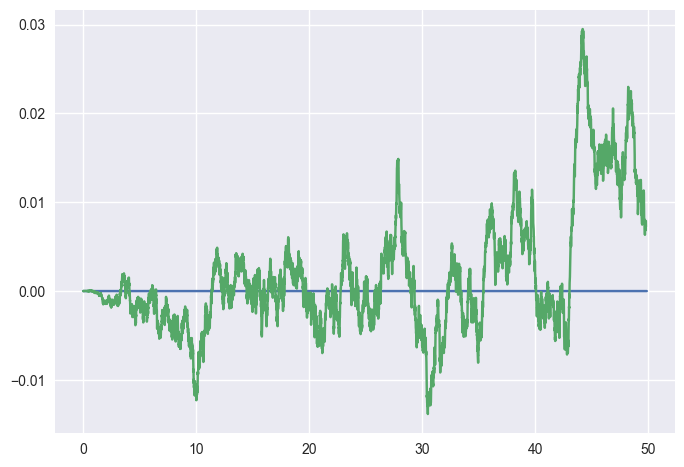

In [73]:
plt.plot(x_true[0,:], x_true[1,:])
plt.plot(x_hat[0,:], x_hat[1,:])
# plt.legend(['True', 'Estimate'])

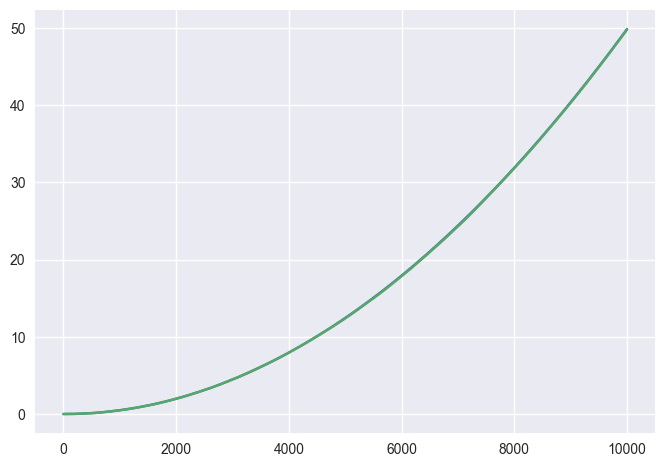

In [74]:
plt.plot(x_true[0,:])
plt.plot(x_hat[0,:])

In [64]:
P[1,1,-1]

0.0017506347410072439